In [1]:
# 安裝套件
!pip install fastbook -q
!pip install timm -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# 讀取套件
from fastbook import *
from fastai.vision.widgets import *
import timm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import shutil
import fastai;
print('fastai verison:', fastai.__version__)
print('torch version:', torch.__version__)

fastai verison: 2.7.19
torch version: 2.6.0+cu124


In [3]:
# 準備資料集
from google.colab import drive
drive.mount('/content/drive')

path = Path('/content/drive/MyDrive/dataset/HW1')
keywords = {'Normal': 'normal chest X-ray', 'Pneumonia': 'chest X-ray pneumonia', 'Tuberculosis': 'chest X-ray tuberculosis', 'COVID-19': 'COVID-19 chest X-ray', 'Cardiomegaly': 'Cardiomegaly X-ray'}
array = keywords.items()
if not path.exists():
  !mkdir -p /content/drive/MyDrive/dataset/HW1
  for key,value in array:
    print(key,value)
    dest = (path/key)
    dest.mkdir(exist_ok=True)
    urls = search_images_ddg(f' {value}',max_images=150)
    download_images(dest, urls=urls)

Mounted at /content/drive


In [4]:
# 清洗資料
fns = get_image_files(path)
failed = verify_images(fns)
for image_path in failed:
    # Check if the file exists before attempting to delete it
    if image_path.exists():
        image_path.unlink() #unlink broken images
    else:
        print(f"Warning: File not found: {image_path}")

In [5]:
# 設定訓練資料路徑
path = Path('/content/drive/MyDrive/dataset/HW1/')
path.ls()

#建立模型權重储存路徑
myPath='/content/drive/MyDrive/dataset/HW1/models'
!mkdir -p $myPath

In [6]:
# 資料讀取框架
dataset = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms= Resize(224),
    get_y=parent_label
)

# 利用框架正式讀取資料
dls = dataset.dataloaders(path,bs=16,num_workers=16)

# 讀取結果
print(dls.c, dls.vocab, len(dls.train_ds), len(dls.valid_ds))

5 ['COVID-19', 'Cardiomegaly', 'Normal', 'Pneumonia', 'Tuberculosis'] 952 238


In [7]:
# 分割資料集
from fastai.data.transforms import RandomSplitter
from fastai.vision.all import *

# Remove split_by_label=True from RandomSplitter
dataset = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # Removed split_by_label=True
    get_y=parent_label
)

訓練資料


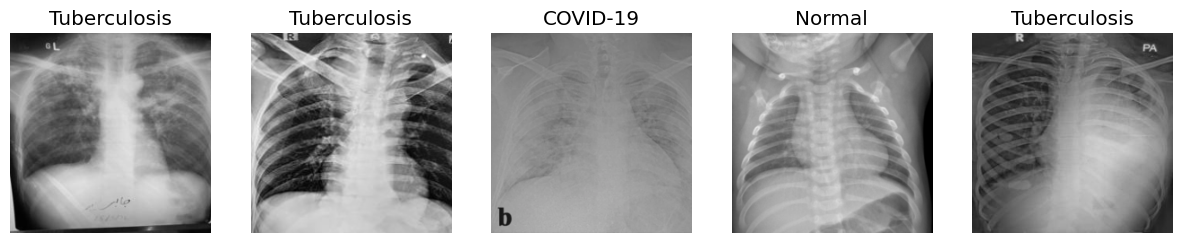

In [8]:
print('訓練資料')
dls.show_batch(max_n=5, nrows=1)

In [9]:
timm. list_models()

['aimv2_1b_patch14_224',
 'aimv2_1b_patch14_336',
 'aimv2_1b_patch14_448',
 'aimv2_3b_patch14_224',
 'aimv2_3b_patch14_336',
 'aimv2_3b_patch14_448',
 'aimv2_huge_patch14_224',
 'aimv2_huge_patch14_336',
 'aimv2_huge_patch14_448',
 'aimv2_large_patch14_224',
 'aimv2_large_patch14_336',
 'aimv2_large_patch14_448',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coa

## Resnet34模型

In [10]:
learn_resnet34 = vision_learner(dls, resnet34, metrics=[accuracy, error_rate], pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 198MB/s]


In [11]:
learn_resnet34. summary()

Sequential (Input shape: 16 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     16 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

In [12]:
learn_resnet34.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.009107,0.191139,0.932773,0.067227,00:35
1,0.461813,0.108823,0.962185,0.037815,00:32
2,0.270030,0.092674,0.957983,0.042017,00:34


In [13]:
myModel=myPath+'/resnet34_stage-1.pkl'
learn_resnet34.export(myModel)

Minimum/10: 9.12e-08, steepest point: 7.59e-07


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.173046,0.083705,0.962185,0.037815,00:40
1,0.156129,0.095459,0.966387,0.033613,00:41
2,0.170760,0.081804,0.966387,0.033613,00:41
3,0.153303,0.084188,0.957983,0.042017,00:35
4,0.184595,0.074920,0.970588,0.029412,00:36
5,0.185741,0.084925,0.970588,0.029412,00:35


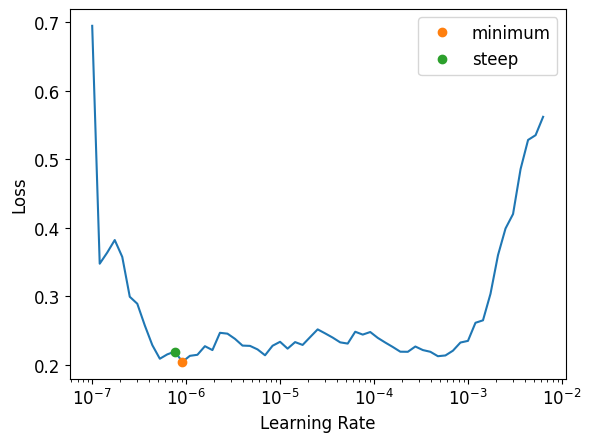

In [15]:
learn_resnet34.unfreeze()
# Decreased end_lr to 10 to explore a smaller learning rate range
lr_min, lr_steep = learn_resnet34.lr_find(suggest_funcs=(minimum, steep), start_lr=1e-7, end_lr=10)
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

learn_resnet34.fit_one_cycle(6, lr_max=slice(lr_min, lr_steep))

Minimum/10: 9.55e-07, steepest point: 1.82e-06


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.173832,0.080557,0.962185,0.037815,00:36
1,0.153529,0.071524,0.970588,0.029412,00:33
2,0.143923,0.078033,0.970588,0.029412,00:35
3,0.157331,0.074726,0.974790,0.025210,00:35
4,0.175437,0.069554,0.966387,0.033613,00:34
5,0.175495,0.069825,0.983193,0.016807,00:36


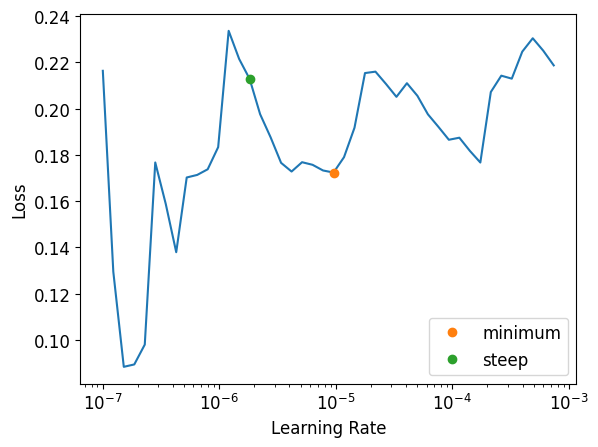

In [16]:
learn_resnet34.unfreeze()
# Decreased end_lr to 10 to explore a smaller learning rate range
lr_min, lr_steep = learn_resnet34.lr_find(suggest_funcs=(minimum, steep), start_lr=1e-7, end_lr=10)
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

learn_resnet34.fit_one_cycle(6, lr_max=slice(lr_min, lr_steep))

In [17]:
myModel=myPath+'/resnet34_stage-2.pkl'
learn_resnet34.export(myModel)

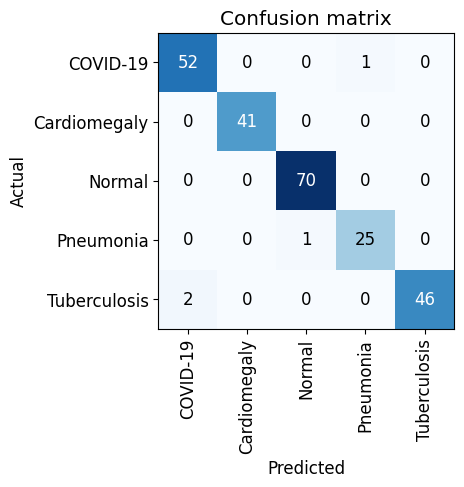

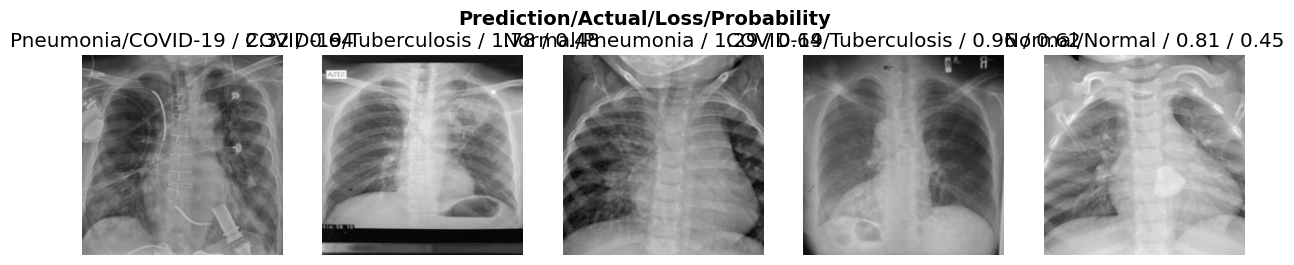

In [18]:
interp = ClassificationInterpretation.from_learner(learn_resnet34)

interp.plot_confusion_matrix()

interp.plot_top_losses(5, nrows=1)

In [19]:
fnames_Normal = get_image_files('/content/drive/MyDrive/dataset/HW1/Normal')
fnames_Pneumonia = get_image_files('/content/drive/MyDrive/dataset/HW1/Pneumonia')
fnames_Tuberculosis = get_image_files('/content/drive/MyDrive/dataset/HW1/Tuberculosis')
fnames_COVID19 = get_image_files('/content/drive/MyDrive/dataset/HW1/COVID19')
fnames_Cardiomegaly = get_image_files('/content/drive/MyDrive/dataset/HW1/Cardiomegaly')

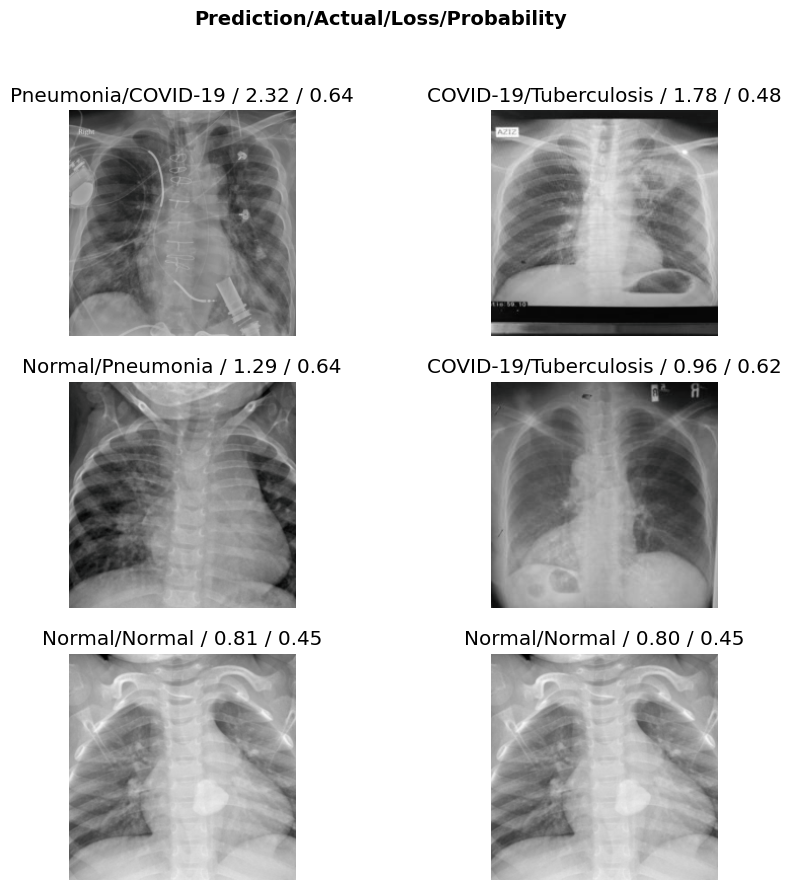

In [20]:
interp.plot_top_losses(6, nrows=3, figsize=(10,10))

In [21]:
from sklearn.metrics import roc_curve, auc

The accuracy is 98.32 %.


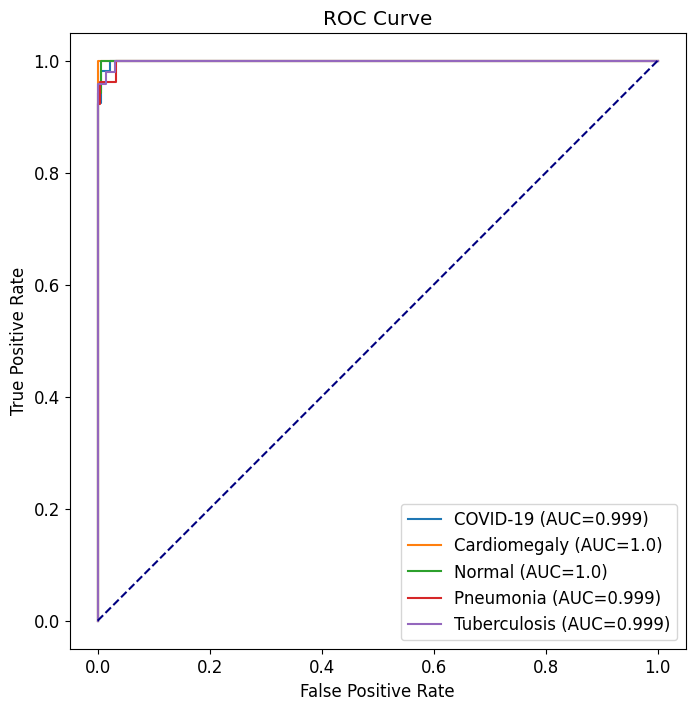

In [22]:
preds, y, loss = learn_resnet34.get_preds(dl=dls.valid, with_loss=True)
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format( 100* round( float(acc), 4)))

class_num = dls.c
class_name = dls.vocab

plt.figure(figsize=(8,8))
for i in range(class_num):
    probs = np.array(preds[:,i])
    # Compute ROC curve
    fpr, tpr, threshold = roc_curve(y, probs, pos_label=i)
    # Compute ROC area
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{0} (AUC={1})'.format(class_name[i], round(roc_auc, 3)))

plt.plot([0,1],[0,1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.axis('square')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

In [23]:
targe_class = 1

The accuracy is 98.32 %.
Area under the curve of ROC in class Cardiomegaly is 1.0


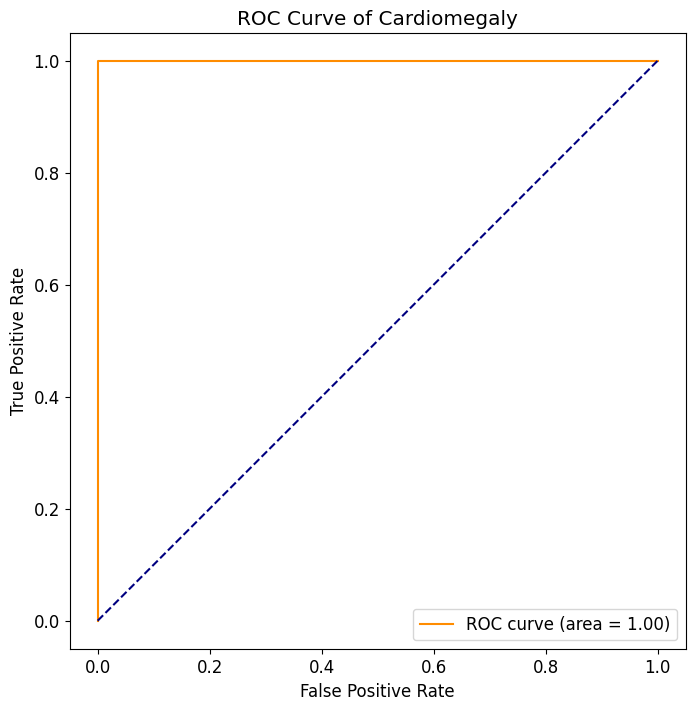

In [24]:
preds, y, loss = learn_resnet34.get_preds(dl=dls.valid, with_loss=True)
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format( 100* round( float(acc), 4)))

probs = np.array(preds[:,targe_class])

# Compute ROC curve
fpr, tpr, threshold = roc_curve(y, probs, pos_label=targe_class)
# Compute ROC area
roc_auc = auc(fpr, tpr)
print('Area under the curve of ROC in class {0} is {1}'.format(dls.vocab[targe_class],roc_auc, 3))

plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.axis('square')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of {0}'.format(dls.vocab[targe_class]))
plt.legend(loc="lower right")

In [25]:
from sklearn.metrics import classification_report

In [26]:
preds, y, loss = learn_resnet34.get_preds(dl=dls.valid, with_loss=True)

print(classification_report(y, preds.argmax(axis=1), target_names=dls.vocab))

              precision    recall  f1-score   support

    COVID-19       0.96      0.98      0.97        53
Cardiomegaly       1.00      1.00      1.00        41
      Normal       0.99      1.00      0.99        70
   Pneumonia       0.96      0.96      0.96        26
Tuberculosis       1.00      0.96      0.98        48

    accuracy                           0.98       238
   macro avg       0.98      0.98      0.98       238
weighted avg       0.98      0.98      0.98       238



In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [28]:
# Model 1
y_true = y # Replace 'y' with the actual variable containing your true labels
# Use preds directly instead of preds.argmax(axis=1)
y_pred1 = preds  # Replace 'preds' with the output from 'learn_resnet34.get_preds'

acc1 = accuracy_score(y_true, y_pred1.argmax(axis=1)) # get argmax for accuracy
precision_micro1 = precision_score(y_true, y_pred1.argmax(axis=1), average='micro')
precision_macro1 = precision_score(y_true, y_pred1.argmax(axis=1), average='macro')
recall_micro1 = recall_score(y_true, y_pred1.argmax(axis=1), average='micro')
recall_macro1 = recall_score(y_true, y_pred1.argmax(axis=1), average='macro')
f1_micro1 = f1_score(y_true, y_pred1.argmax(axis=1), average='micro')
f1_macro1 = f1_score(y_true, y_pred1.argmax(axis=1), average='macro')
# Use predictions (probabilities) for roc_auc_score
auc_weighted1 = roc_auc_score(y_true, y_pred1, average='weighted', multi_class='ovr')
auc_macro1 = roc_auc_score(y_true, y_pred1, average='macro', multi_class='ovr')

## VGG16模型

In [29]:
from fastai.vision.all import *

learn_VGG16 = vision_learner(dls, vgg16_bn, metrics=[accuracy, error_rate], pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:06<00:00, 89.8MB/s]


In [30]:
learn_VGG16. summary()

Sequential (Input shape: 16 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 64 x 224 x 224 
Conv2d                                    1792       False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36928      False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     16 x 64 x 112 x 112 
MaxPool2d                                                      
____________________________________________________________________________
                     16 x 128 x 112 x 11 
Conv2d                                    73856      False     
BatchNorm2d                               256        True      
ReLU                               

In [31]:
learn_VGG16.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.958281,0.145720,0.966387,0.033613,00:38
1,0.390417,0.079168,0.974790,0.025210,00:35
2,0.207803,0.061064,0.983193,0.016807,00:37


In [32]:
myModel=myPath+'/VGG16_stage-1.pkl'
learn_VGG16.export(myModel)

Minimum/10: 9.33e-06, steepest point: 1.20e-06


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.179903,0.062323,0.983193,0.016807,00:39
1,0.157423,0.053272,0.983193,0.016807,00:38
2,0.151403,0.051898,0.991597,0.008403,00:35
3,0.120398,0.049032,0.987395,0.012605,00:38
4,0.108560,0.048052,0.987395,0.012605,00:38
5,0.102968,0.050699,0.987395,0.012605,00:36


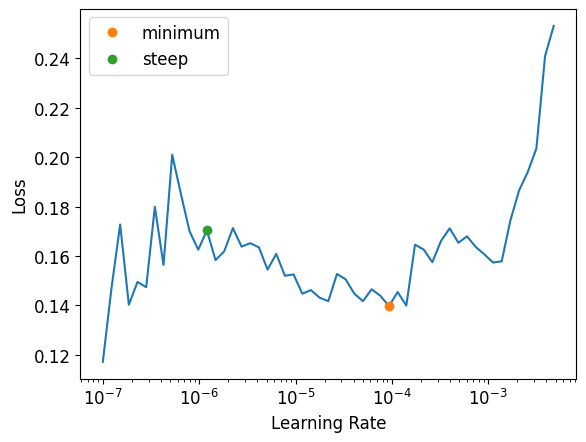

In [33]:
learn_VGG16.unfreeze()
# Decreased end_lr to 10 to explore a smaller learning rate range
lr_min, lr_steep = learn_VGG16.lr_find(suggest_funcs=(minimum, steep), start_lr=1e-7, end_lr=10)
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

learn_VGG16.fit_one_cycle(6, lr_max=slice(lr_min, lr_steep))

Minimum/10: 7.76e-07, steepest point: 9.77e-07


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.134242,0.047589,0.987395,0.012605,00:39
1,0.138751,0.049012,0.987395,0.012605,00:36
2,0.108456,0.045579,0.991597,0.008403,00:38
3,0.103703,0.042921,0.987395,0.012605,00:40
4,0.086795,0.044712,0.991597,0.008403,00:36
5,0.078805,0.045902,0.987395,0.012605,00:38


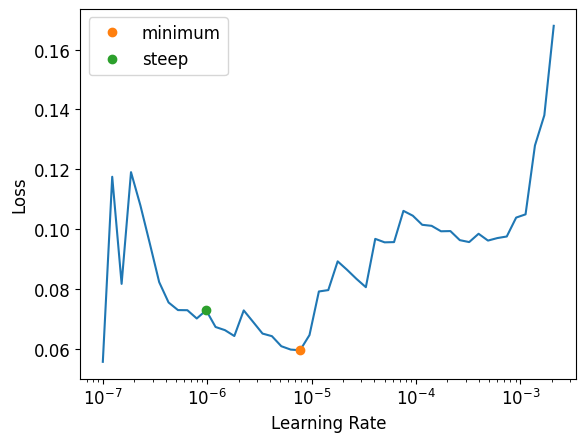

In [34]:
learn_VGG16.unfreeze()
# Decreased end_lr to 10 to explore a smaller learning rate range
lr_min, lr_steep = learn_VGG16.lr_find(suggest_funcs=(minimum, steep), start_lr=1e-7, end_lr=10)
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

learn_VGG16.fit_one_cycle(6, lr_max=slice(lr_min, lr_steep))

In [35]:
myModel=myPath+'/VGG16_stage-2.pkl'
learn_VGG16.export(myModel)

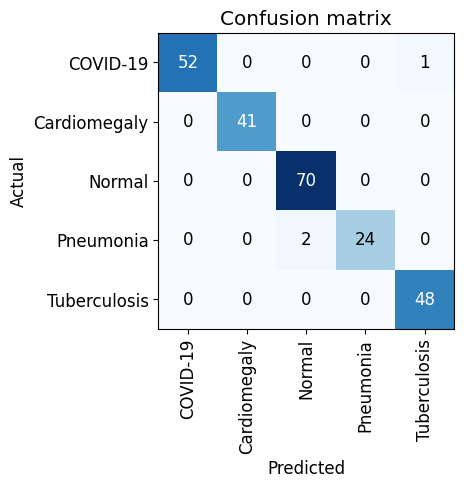

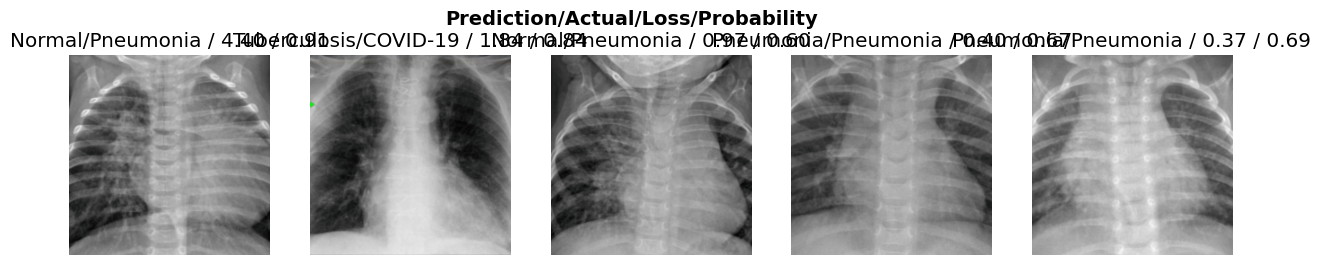

In [36]:
interp = ClassificationInterpretation.from_learner(learn_VGG16)

interp.plot_confusion_matrix()

interp.plot_top_losses(5, nrows=1)

In [37]:
fnames_Normal = get_image_files('/content/drive/MyDrive/dataset/HW1/Normal')
fnames_Pneumonia = get_image_files('/content/drive/MyDrive/dataset/HW1/Pneumonia')
fnames_Tuberculosis = get_image_files('/content/drive/MyDrive/dataset/HW1/Tuberculosis')
fnames_COVID19 = get_image_files('/content/drive/MyDrive/dataset/HW1/COVID19')
fnames_Cardiomegaly = get_image_files('/content/drive/MyDrive/dataset/HW1/Cardiomegaly')

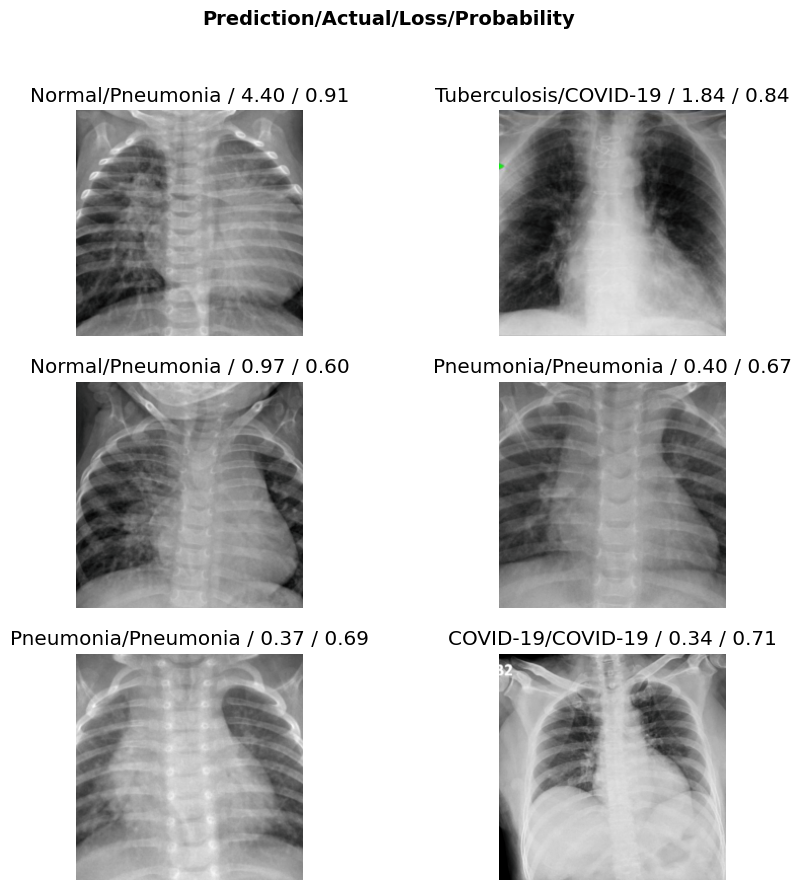

In [38]:
interp.plot_top_losses(6, nrows=3, figsize=(10,10))

In [39]:
from sklearn.metrics import roc_curve, auc

The accuracy is 98.74000000000001 %.


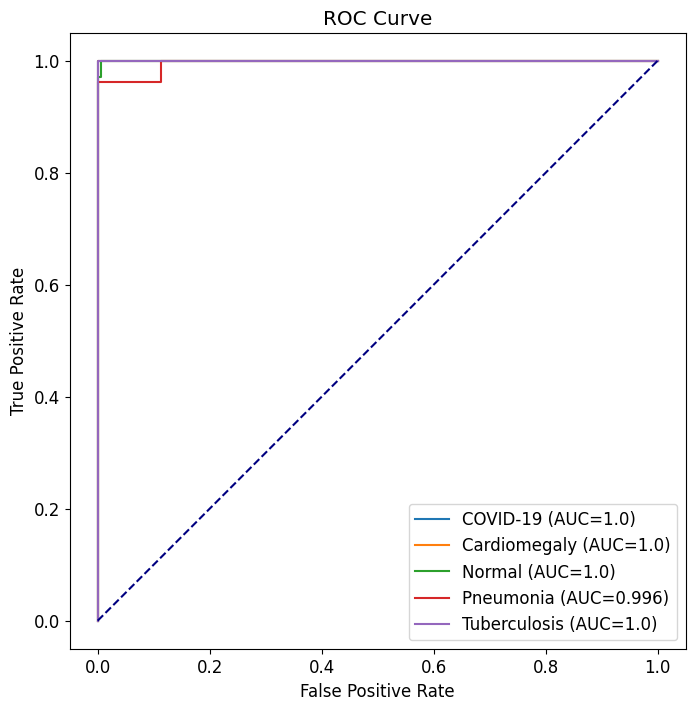

In [40]:
preds, y, loss = learn_VGG16.get_preds(dl=dls.valid, with_loss=True)
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format( 100* round( float(acc), 4)))

class_num = dls.c
class_name = dls.vocab

plt.figure(figsize=(8,8))
for i in range(class_num):
    probs = np.array(preds[:,i])
    # Compute ROC curve
    fpr, tpr, threshold = roc_curve(y, probs, pos_label=i)
    # Compute ROC area
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{0} (AUC={1})'.format(class_name[i], round(roc_auc, 3)))

plt.plot([0,1],[0,1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.axis('square')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

In [41]:
targe_class = 1

The accuracy is 98.74000000000001 %.
Area under the curve of ROC in class Cardiomegaly is 1.0


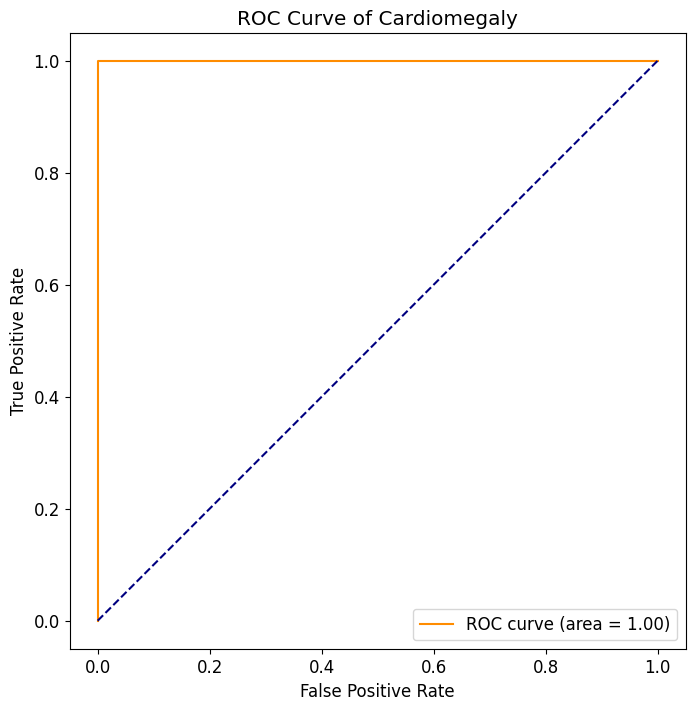

In [42]:
preds, y, loss = learn_VGG16.get_preds(dl=dls.valid, with_loss=True)
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format( 100* round( float(acc), 4)))

probs = np.array(preds[:,targe_class])

# Compute ROC curve
fpr, tpr, threshold = roc_curve(y, probs, pos_label=targe_class)
# Compute ROC area
roc_auc = auc(fpr, tpr)
print('Area under the curve of ROC in class {0} is {1}'.format(dls.vocab[targe_class],roc_auc, 3))

plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.axis('square')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of {0}'.format(dls.vocab[targe_class]))
plt.legend(loc="lower right")

In [43]:
from sklearn.metrics import classification_report

In [44]:
preds, y, loss = learn_VGG16.get_preds(dl=dls.valid, with_loss=True)

print(classification_report(y, preds.argmax(axis=1), target_names=dls.vocab))

              precision    recall  f1-score   support

    COVID-19       1.00      0.98      0.99        53
Cardiomegaly       1.00      1.00      1.00        41
      Normal       0.97      1.00      0.99        70
   Pneumonia       1.00      0.92      0.96        26
Tuberculosis       0.98      1.00      0.99        48

    accuracy                           0.99       238
   macro avg       0.99      0.98      0.99       238
weighted avg       0.99      0.99      0.99       238



In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [46]:
# Model 2
y_true = y # Replace 'y' with the actual variable containing your true labels
# Use preds directly instead of preds.argmax(axis=1)
y_pred2 = preds  # Replace 'preds' with the output from 'learn_resnet34.get_preds'

acc2 = accuracy_score(y_true, y_pred2.argmax(axis=1)) # get argmax for accuracy
precision_micro2 = precision_score(y_true, y_pred2.argmax(axis=1), average='micro')
precision_macro2 = precision_score(y_true, y_pred2.argmax(axis=1), average='macro')
recall_micro2 = recall_score(y_true, y_pred2.argmax(axis=1), average='micro')
recall_macro2 = recall_score(y_true, y_pred2.argmax(axis=1), average='macro')
f1_micro2 = f1_score(y_true, y_pred2.argmax(axis=1), average='micro')
f1_macro2 = f1_score(y_true, y_pred2.argmax(axis=1), average='macro')
# Use predictions (probabilities) for roc_auc_score
auc_weighted2 = roc_auc_score(y_true, y_pred2, average='weighted', multi_class='ovr')
auc_macro2 = roc_auc_score(y_true, y_pred2, average='macro', multi_class='ovr')

## DenseNet121模型

In [47]:
from fastai.vision.all import *
import timm

learn_DenseNet121 = vision_learner(dls, timm.models.densenet121, metrics=[accuracy, error_rate], pretrained=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

In [48]:
learn_DenseNet121. summary()

Sequential (Input shape: 16 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 64 x 112 x 112 
Conv2d                                    9408       False     
Identity                                                       
ReLU                                                           
____________________________________________________________________________
                     16 x 64 x 56 x 56   
MaxPool2d                                                      
Identity                                                       
ReLU                                                           
____________________________________________________________________________
                     16 x 128 x 56 x 56  
Conv2d                                    8192       False     
Identity                                                       
ReLU                                                           
___________________________________

In [49]:
learn_DenseNet121.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.898081,0.226512,0.928571,0.071429,00:37
1,0.425822,0.087942,0.974790,0.025210,00:40
2,0.234825,0.097904,0.957983,0.042017,00:42


In [50]:
myModel=myPath+'/DenseNet121_stage-1.pkl'
learn_DenseNet121.export(myModel)

Minimum/10: 1.10e-05, steepest point: 7.59e-07


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.191588,0.093241,0.966387,0.033613,00:41
1,0.192036,0.085360,0.974790,0.025210,00:41
2,0.184184,0.052942,0.991597,0.008403,00:42
3,0.145572,0.088228,0.962185,0.037815,00:40
4,0.117301,0.058353,0.983193,0.016807,00:42
5,0.116736,0.068506,0.978992,0.021008,00:42


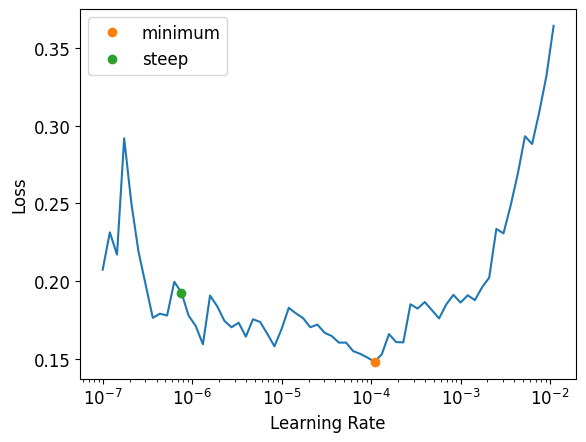

In [51]:
learn_DenseNet121.unfreeze()
# Decreased end_lr to 10 to explore a smaller learning rate range
lr_min, lr_steep = learn_DenseNet121.lr_find(suggest_funcs=(minimum, steep), start_lr=1e-7, end_lr=10)
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

learn_DenseNet121.fit_one_cycle(6, lr_max=slice(lr_min, lr_steep))

Minimum/10: 2.29e-07, steepest point: 7.59e-07


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.130370,0.082614,0.962185,0.037815,00:40
1,0.161080,0.040507,0.995798,0.004202,00:40
2,0.145262,0.063586,0.978992,0.021008,00:41
3,0.148398,0.051416,0.987395,0.012605,00:42
4,0.146831,0.054934,0.983193,0.016807,00:42
5,0.159029,0.087795,0.953781,0.046218,00:42


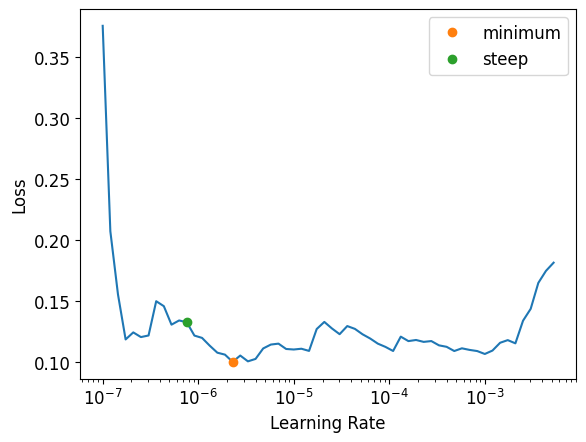

In [52]:
learn_DenseNet121.unfreeze()
# Decreased end_lr to 10 to explore a smaller learning rate range
lr_min, lr_steep = learn_DenseNet121.lr_find(suggest_funcs=(minimum, steep), start_lr=1e-7, end_lr=10)
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

learn_DenseNet121.fit_one_cycle(6, lr_max=slice(lr_min, lr_steep))

In [53]:
myModel=myPath+'/DenseNet121_stage-2.pkl'
learn_resnet34.export(myModel)

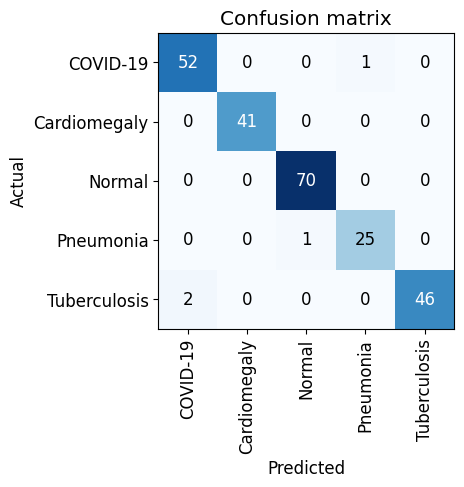

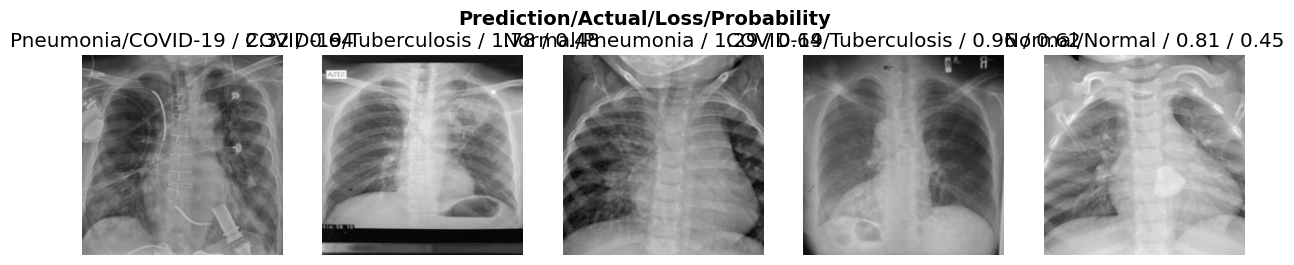

In [54]:
interp = ClassificationInterpretation.from_learner(learn_resnet34)

interp.plot_confusion_matrix()

interp.plot_top_losses(5, nrows=1)

In [55]:
fnames_Normal = get_image_files('/content/drive/MyDrive/dataset/HW1/Normal')
fnames_Pneumonia = get_image_files('/content/drive/MyDrive/dataset/HW1/Pneumonia')
fnames_Tuberculosis = get_image_files('/content/drive/MyDrive/dataset/HW1/Tuberculosis')
fnames_COVID19 = get_image_files('/content/drive/MyDrive/dataset/HW1/COVID19')
fnames_Cardiomegaly = get_image_files('/content/drive/MyDrive/dataset/HW1/Cardiomegaly')

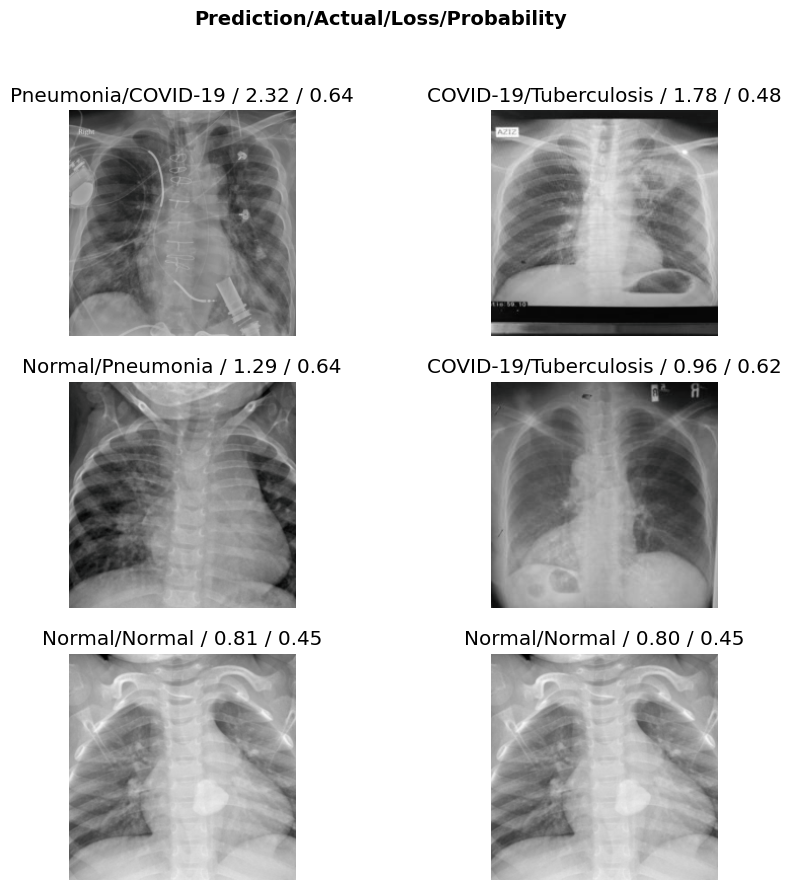

In [56]:
interp.plot_top_losses(6, nrows=3, figsize=(10,10))

In [57]:
from sklearn.metrics import roc_curve, auc

The accuracy is 95.38 %.


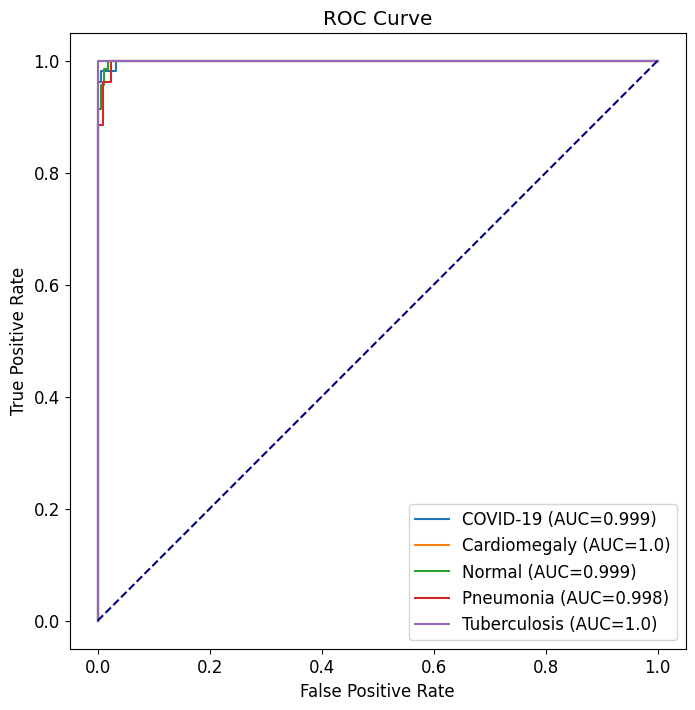

In [58]:
preds, y, loss = learn_DenseNet121.get_preds(dl=dls.valid, with_loss=True)
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format( 100* round( float(acc), 4)))

class_num = dls.c
class_name = dls.vocab

plt.figure(figsize=(8,8))
for i in range(class_num):
    probs = np.array(preds[:,i])
    # Compute ROC curve
    fpr, tpr, threshold = roc_curve(y, probs, pos_label=i)
    # Compute ROC area
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{0} (AUC={1})'.format(class_name[i], round(roc_auc, 3)))

plt.plot([0,1],[0,1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.axis('square')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

In [59]:
targe_class = 1

The accuracy is 95.38 %.
Area under the curve of ROC in class Cardiomegaly is 1.0


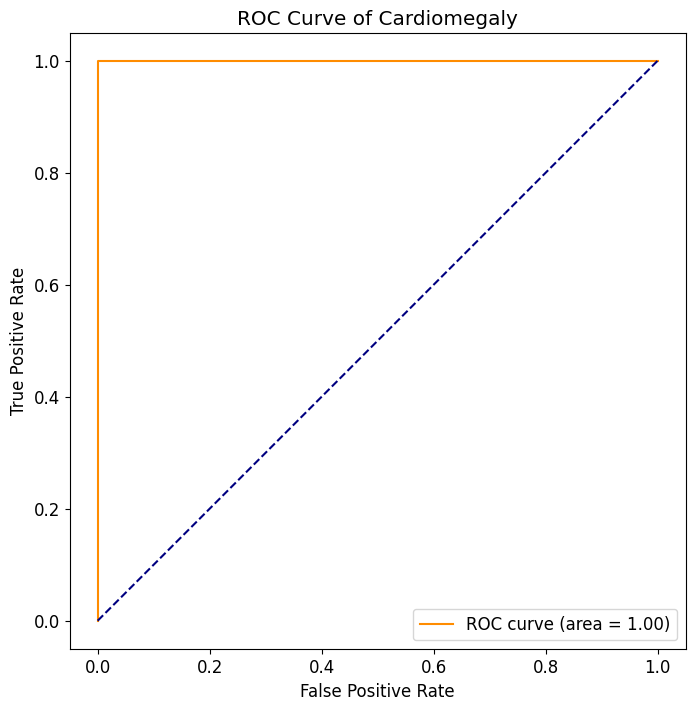

In [60]:
preds, y, loss = learn_DenseNet121.get_preds(dl=dls.valid, with_loss=True)
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format( 100* round( float(acc), 4)))

probs = np.array(preds[:,targe_class])

# Compute ROC curve
fpr, tpr, threshold = roc_curve(y, probs, pos_label=targe_class)
# Compute ROC area
roc_auc = auc(fpr, tpr)
print('Area under the curve of ROC in class {0} is {1}'.format(dls.vocab[targe_class],roc_auc, 3))

plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.axis('square')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of {0}'.format(dls.vocab[targe_class]))
plt.legend(loc="lower right")

In [61]:
from sklearn.metrics import classification_report

In [62]:
preds, y, loss = learn_DenseNet121.get_preds(dl=dls.valid, with_loss=True)

print(classification_report(y, preds.argmax(axis=1), target_names=dls.vocab))

              precision    recall  f1-score   support

    COVID-19       0.90      0.98      0.94        53
Cardiomegaly       1.00      0.95      0.97        41
      Normal       0.96      0.99      0.97        70
   Pneumonia       1.00      0.73      0.84        26
Tuberculosis       0.96      1.00      0.98        48

    accuracy                           0.95       238
   macro avg       0.96      0.93      0.94       238
weighted avg       0.96      0.95      0.95       238



In [63]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [64]:
# Model 3
y_true = y # Replace 'y' with the actual variable containing your true labels
# Use preds directly instead of preds.argmax(axis=1)
y_pred3 = preds  # Replace 'preds' with the output from 'learn_resnet34.get_preds'

acc3 = accuracy_score(y_true, y_pred3.argmax(axis=1)) # get argmax for accuracy
precision_micro3 = precision_score(y_true, y_pred3.argmax(axis=1), average='micro')
precision_macro3 = precision_score(y_true, y_pred3.argmax(axis=1), average='macro')
recall_micro3 = recall_score(y_true, y_pred3.argmax(axis=1), average='micro')
recall_macro3 = recall_score(y_true, y_pred3.argmax(axis=1), average='macro')
f1_micro3 = f1_score(y_true, y_pred3.argmax(axis=1), average='micro')
f1_macro3 = f1_score(y_true, y_pred3.argmax(axis=1), average='macro')
# Use predictions (probabilities) for roc_auc_score
auc_weighted3 = roc_auc_score(y_true, y_pred3, average='weighted', multi_class='ovr')
auc_macro3 = roc_auc_score(y_true, y_pred3, average='macro', multi_class='ovr')

In [65]:
import pandas as pd

data = {
    'Model': ['Model 1', 'Model 2', 'Model 3'],
    'Accuracy': [acc1, acc2, acc3],
    'Precision (Micro)': [precision_micro1, precision_micro2, precision_micro3],
    'Precision (Macro)': [precision_macro1, precision_macro2, precision_macro3],
    'Recall (Micro)': [recall_micro1, recall_micro2, recall_micro3],
    'Recall (Macro)': [recall_macro1, recall_macro2, recall_macro3],
    'F1-Score (Micro)': [f1_micro1, f1_micro2, f1_micro3],
    'F1-Score (Macro)': [f1_macro1, f1_macro2, f1_macro3],
    'AUC (Weighted)': [auc_weighted1, auc_weighted2, auc_weighted3],
    'AUC (Macro)': [auc_macro1, auc_macro2, auc_macro3]
}

df = pd.DataFrame(data)

# 顯示表格
df

,Model,Accuracy,Precision (Micro),Precision (Macro),Recall (Micro),Recall (Macro),F1-Score (Micro),F1-Score (Macro),AUC (Weighted),AUC (Macro)
0,Model 1,0.983193,0.983193,0.982083,0.983193,0.980201,0.983193,0.981026,0.999383,0.999302
1,Model 2,0.987395,0.987395,0.990363,0.987395,0.980842,0.987395,0.985216,0.999474,0.999095
2,Model 3,0.953782,0.953782,0.962977,0.953782,0.929767,0.953782,0.941561,0.999413,0.999361


## 繪製Grad-CAM

In [66]:
class Hook():
  def __init__(self, m):
    self.hook = m.register_forward_hook(self.hook_func)
  def hook_func(self, m, i, o): self.stored = o.detach().clone()
  def __enter__(self, *args): return self
  def __exit__(self, *args): self.hook.remove()

In [67]:
class HookBwd():
  def __init__(self, m):
    self.hook = m.register_backward_hook(self.hook_func)
  def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
  def __enter__(self, *args): return self
  def __exit__(self, *args): self.hook.remove()

In [68]:
myModel='/content/drive/MyDrive/dataset/HW1/models/resnet34_stage-2.pkl'
learn_resnet34 = load_learner(myModel)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [69]:
## 執行預測 - method I
fnames_class0 = get_image_files('/content/drive/MyDrive/dataset/HW1/COVID-19')
fnames_class1 = get_image_files('/content/drive/MyDrive/dataset/HW1/Pneumonia')

In [70]:
print(f"fnames_class1: {fnames_class1}")
if not fnames_class1:
    print("fnames_class1 is empty!")

fnames_class1: [Path('/content/drive/MyDrive/dataset/HW1/Pneumonia/person23_bacteria_90.jpeg'), Path('/content/drive/MyDrive/dataset/HW1/Pneumonia/person23_bacteria_84.jpeg'), Path('/content/drive/MyDrive/dataset/HW1/Pneumonia/person22_bacteria_76.jpeg'), Path('/content/drive/MyDrive/dataset/HW1/Pneumonia/person24_bacteria_109.jpeg'), Path('/content/drive/MyDrive/dataset/HW1/Pneumonia/person23_bacteria_103.jpeg'), Path('/content/drive/MyDrive/dataset/HW1/Pneumonia/person23_bacteria_95.jpeg'), Path('/content/drive/MyDrive/dataset/HW1/Pneumonia/person23_bacteria_101.jpeg'), Path('/content/drive/MyDrive/dataset/HW1/Pneumonia/person22_bacteria_77.jpeg'), Path('/content/drive/MyDrive/dataset/HW1/Pneumonia/person23_bacteria_100.jpeg'), Path('/content/drive/MyDrive/dataset/HW1/Pneumonia/person23_bacteria_96.jpeg'), Path('/content/drive/MyDrive/dataset/HW1/Pneumonia/person23_bacteria_88.jpeg'), Path('/content/drive/MyDrive/dataset/HW1/Pneumonia/person24_bacteria_112.jpeg'), Path('/content/driv

In [71]:
test_dl = learn_resnet34.dls.test_dl(fnames_class1,  with_label=True)
print(len(test_dl.get_idxs()))

168


In [72]:
from torchvision.transforms.functional import to_tensor
fn = test_dl.items[0]
x_dec = PILImage.create(fn);

#Resize: 224
rsz = Resize(224, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros)
x_dec = rsz(x_dec)
x = to_tensor(x_dec)

x.unsqueeze_(0)
print(x.shape,type(x))

torch.Size([1, 3, 224, 224]) <class 'torch.Tensor'>


In [73]:
learn_resnet34.dls.vocab

['COVID-19', 'Cardiomegaly', 'Normal', 'Pneumonia', 'Tuberculosis']

In [74]:
cls = 1
with HookBwd(learn_resnet34.model[0]) as hookg:
  with Hook(learn_resnet34.model[0]) as hook:
    output = learn_resnet34.model.eval()(x.cpu())
    act = hook.stored
  output[0,cls].backward()
  grad = hookg.stored

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [75]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

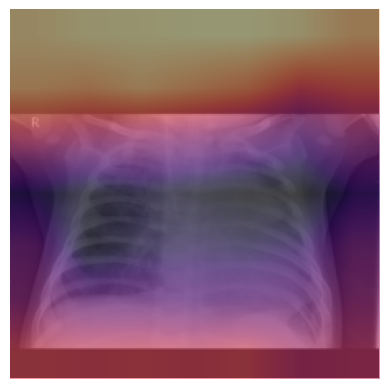

In [76]:
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0), interpolation='bilinear', cmap='magma');